<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [ ]:
# Installation
!pip install yfinance
!pip install yahoo_fin --upgrade


In [ ]:
import random

## Hyper parameters
history = "5y"
buy_trigger = 3                           # times standard deviation
sell_trigger = 1                          # times the avg cost of the security to grow before we sell
security_age = 15                         # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000                # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"                         # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5                     # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 50                  # number of backtests to run
backtest_days = random.sample(range(100, 800), backtest_iterations) # starting days for back testing
backtest_days.sort()
prefer_beta = True

starting_balance = 10000                  # seed money to start investing
current_account = original_balance = starting_balance
portfolio = {}

# Display test results
print_final_portfolio = False              # Prints the portfolio list at the end of each backtest iteration
plot_every_test_graph = True              # Prints the model performance during the back end against s&P500
plot_summary_graph = True                  # prints the summary graph

In [ ]:
tests = [
    {
        "Name": "Test 1",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1000,
        "prefer_beta": True,
        "mean_type": "+ve"
     },
     {
        "Name": "Test 2",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 15,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "+ve"
     },
     {
        "Name": "Test 3",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "+ve"
     },
     {
        "Name": "Test 4",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 1000,
        "lockin_gains_factor": 1.1,
        "prefer_beta": False,
        "mean_type": "+ve"
     },
     {
        "Name": "Test 5",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": "+ve"
     },
     {
        "Name": "Test 6",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": False,
        "mean_type": "+ve"
     },
    {
        "Name": "Test 7",
        "buy_trigger": 2,
        "sell_trigger": 1,
        "security_age": 90,
        "lockin_gains_factor": 1.1,
        "prefer_beta": True,
        "mean_type": ""
     },
]

tests_to_run = [5]

In [ ]:
import yfinance as yahooFinance
import yahoo_fin.stock_info as si
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
import pprint

pp = pprint.PrettyPrinter(indent=4)

stocks = si.tickers_sp500()
indices = ['^IXIC', '^GSPC', '^DJI']
stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()
indices_ts = pd.DataFrame()

for idx in indices:
    data = yahooFinance.Ticker(idx).history(period=history)
    d = data.copy()[['Open', 'Close']]
    indices_ts[idx+"_Open"] = d['Open']
    indices_ts[idx+"_Close"] = d['Close']

betas = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/betas.csv")
betas = betas.drop(['index', 'Attribute', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1)
betas = betas.rename(columns={"Recent": "Beta"})
betas = betas.set_index('Ticker')
for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period=history)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock] = (d['Close'] - d['Open']) * 100/d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()


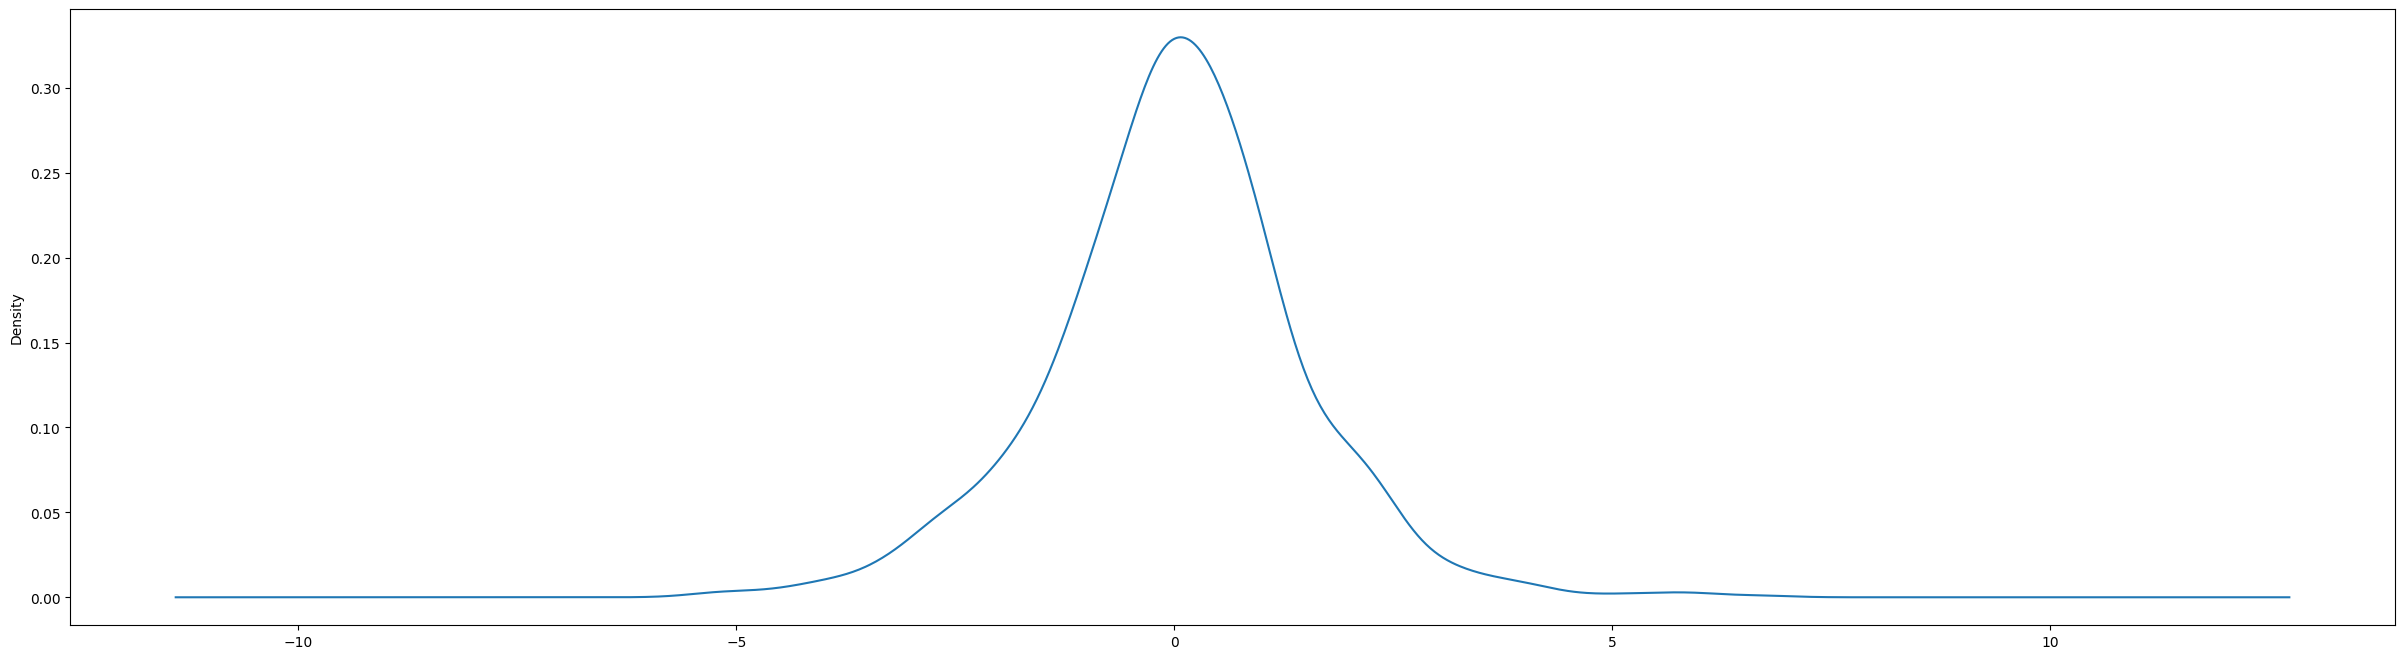

In [ ]:

for stock in stocks[:1]:
    #latest[stock] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']

    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock, title="Stocks Daily Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock, data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();

In [ ]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title="Daily Stock Price change", markers=True)
fig.show()


In [ ]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio):
  latest = {}
  for s in stocks:
      latest[s] = (stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"])* 100 /stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean_type != "+ve" or mean['mean'] > 0) & (latest_diff['diff'] < 0) & (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)
  latest_diff['beta'] = betas['Beta']

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s] * avg / 100 <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        latest_diff.at[s, 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        latest_diff.at[s, 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  sell_stocks = latest_diff[latest_diff['sell']]
  buy_stocks = latest_diff[latest_diff['buy']]
  if prefer_beta:
    buy_stocks = buy_stocks.sort_values('beta',ascending=False)
  return sell_stocks, buy_stocks


In [ ]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  original_balance = starting_balance
  current_account = original_balance
  portfolio = {}

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  cash_inhand = []
  for backtest_start_date in stocks_ts.index[idx:]:
      sell, buy = getsellbuy(backtest_start_date, portfolio)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. Beta
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          for i in range(max_stocks_to_buy):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      cash_inhand.append(current_account)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)
  return calculate_networth(backtest_start_date), current_account, price_movement, cash_inhand

In [ ]:

def run_backtest():
  nws = {}
  sp_ret = {}
  for i in backtest_days:
    tradingdays_togoback = i
    networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
    # normalize s&p500 for starting balance
    idx_list = list(indices_ts.loc[indices_ts.index[-tradingdays_togoback:], "^GSPC_Close"] * starting_balance/indices_ts.loc[indices_ts.index[-tradingdays_togoback], "^GSPC_Close"])
    pm_pct = (pm[-1]-pm[0])*100/pm[0]
    d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list, "Cash_In_Hand": cih})
    d.index = indices_ts.index[-tradingdays_togoback:]
    idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
    print("Total networth: %d (Cash %d) after going back %d days (%s)" % (networth, current_account, tradingdays_togoback, stocks_ts.index[-tradingdays_togoback]))
    print("Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct))
    if print_final_portfolio:
      pp.pprint(portfolio)
    nws[i] = networth
    sp_ret[i] = idx_list[-1]
    if plot_every_test_graph:
      fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%% starting at %s" % (pm_pct, idx_pct, stocks_ts.index[-tradingdays_togoback]), markers=True)
      fig.show()

  if plot_summary_graph:
    plt.plot(nws.keys(), nws.values(), color="green", label='Model')
    plt.plot(sp_ret.keys(), sp_ret.values(), color="blue", label='S&P 500')
    plt.title("Networth at the end of each iteration")
    plt.xlabel('Days') 
    plt.ylabel('Networth')
    plt.legend()
    plt.show()
    print(sum(nws.values())/len(nws))

Test Parameters for Test 5
{   'Name': 'Test 5',
    'buy_trigger': 2,
    'lockin_gains_factor': 1.1,
    'mean_type': '+ve',
    'prefer_beta': True,
    'security_age': 90,
    'sell_trigger': 1}
Total networth: 11517 (Cash 439) after going back 101 days (2022-11-07 00:00:00-05:00)
Model (15.177670)% vs S&P Performance (8.345847)%


Total networth: 11837 (Cash 1855) after going back 110 days (2022-10-25 00:00:00-04:00)
Model (18.373161)% vs S&P Performance (6.877224)%


Total networth: 12487 (Cash 5478) after going back 113 days (2022-10-20 00:00:00-04:00)
Model (24.878297)% vs S&P Performance (12.513837)%


Total networth: 12427 (Cash 2395) after going back 121 days (2022-10-10 00:00:00-04:00)
Model (24.278641)% vs S&P Performance (14.176761)%


Total networth: 11292 (Cash 599) after going back 139 days (2022-09-14 00:00:00-04:00)
Model (12.925357)% vs S&P Performance (4.523551)%


Total networth: 11285 (Cash 2209) after going back 169 days (2022-08-02 00:00:00-04:00)
Model (12.853223)% vs S&P Performance (0.814429)%


Total networth: 13799 (Cash 3329) after going back 200 days (2022-06-16 00:00:00-04:00)
Model (37.990109)% vs S&P Performance (12.483459)%


Total networth: 13223 (Cash 3613) after going back 203 days (2022-06-13 00:00:00-04:00)
Model (32.236894)% vs S&P Performance (9.997784)%


Total networth: 12285 (Cash 2250) after going back 222 days (2022-05-16 00:00:00-04:00)
Model (22.857749)% vs S&P Performance (2.906673)%


Total networth: 13720 (Cash 7283) after going back 227 days (2022-05-09 00:00:00-04:00)
Model (37.204601)% vs S&P Performance (3.339057)%


Total networth: 12501 (Cash 5082) after going back 231 days (2022-05-03 00:00:00-04:00)
Model (25.015860)% vs S&P Performance (-1.220703)%


Total networth: 12690 (Cash 5064) after going back 244 days (2022-04-13 00:00:00-04:00)
Model (26.909317)% vs S&P Performance (-7.243305)%


Total networth: 11040 (Cash 3495) after going back 257 days (2022-03-25 00:00:00-04:00)
Model (10.404405)% vs S&P Performance (-9.212960)%


Total networth: 11035 (Cash 1045) after going back 274 days (2022-03-02 00:00:00-05:00)
Model (10.359918)% vs S&P Performance (-5.973507)%


Total networth: 12358 (Cash 2641) after going back 282 days (2022-02-17 00:00:00-05:00)
Model (23.586655)% vs S&P Performance (-5.838695)%


Total networth: 11280 (Cash 5791) after going back 290 days (2022-02-07 00:00:00-05:00)
Model (12.802257)% vs S&P Performance (-8.014513)%


Total networth: 11239 (Cash 589) after going back 292 days (2022-02-03 00:00:00-05:00)
Model (12.399300)% vs S&P Performance (-7.882410)%


Total networth: 11062 (Cash 3703) after going back 296 days (2022-01-28 00:00:00-05:00)
Model (10.628863)% vs S&P Performance (-6.934809)%


Total networth: 11018 (Cash 680) after going back 299 days (2022-01-25 00:00:00-05:00)
Model (10.182058)% vs S&P Performance (-5.324069)%


Total networth: 10766 (Cash 1538) after going back 328 days (2021-12-13 00:00:00-05:00)
Model (7.667721)% vs S&P Performance (-11.661253)%


Total networth: 11755 (Cash 1148) after going back 335 days (2021-12-02 00:00:00-05:00)
Model (17.553671)% vs S&P Performance (-9.888146)%


Total networth: 10375 (Cash 1356) after going back 336 days (2021-12-01 00:00:00-05:00)
Model (3.759376)% vs S&P Performance (-8.609059)%


Total networth: 12282 (Cash 2247) after going back 341 days (2021-11-23 00:00:00-05:00)
Model (22.827602)% vs S&P Performance (-12.070489)%


Total networth: 12802 (Cash 1779) after going back 370 days (2021-10-13 00:00:00-04:00)
Model (28.021610)% vs S&P Performance (-5.483525)%


Total networth: 13854 (Cash 6792) after going back 386 days (2021-09-21 00:00:00-04:00)
Model (38.540314)% vs S&P Performance (-5.274923)%


Total networth: 12280 (Cash 1260) after going back 412 days (2021-08-13 00:00:00-04:00)
Model (22.807555)% vs S&P Performance (-7.687785)%


Total networth: 12593 (Cash 1348) after going back 444 days (2021-06-29 00:00:00-04:00)
Model (25.937493)% vs S&P Performance (-3.897899)%


Total networth: 13442 (Cash 3680) after going back 461 days (2021-06-04 00:00:00-04:00)
Model (34.420057)% vs S&P Performance (-2.491326)%


Total networth: 13340 (Cash 3011) after going back 463 days (2021-06-02 00:00:00-04:00)
Model (33.406895)% vs S&P Performance (-1.986881)%


Total networth: 14168 (Cash 4025) after going back 466 days (2021-05-27 00:00:00-04:00)
Model (41.689196)% vs S&P Performance (-1.817955)%


Total networth: 13471 (Cash 2998) after going back 491 days (2021-04-22 00:00:00-04:00)
Model (34.712107)% vs S&P Performance (-0.253211)%


Total networth: 13707 (Cash 1972) after going back 504 days (2021-04-05 00:00:00-04:00)
Model (37.072344)% vs S&P Performance (1.142739)%


Total networth: 15300 (Cash 6197) after going back 517 days (2021-03-16 00:00:00-04:00)
Model (53.004648)% vs S&P Performance (4.083059)%


Total networth: 13647 (Cash 6039) after going back 545 days (2021-02-03 00:00:00-05:00)
Model (36.478873)% vs S&P Performance (7.684772)%


Total networth: 13738 (Cash 440) after going back 560 days (2021-01-12 00:00:00-05:00)
Model (37.381730)% vs S&P Performance (8.505753)%


Total networth: 15182 (Cash 5889) after going back 576 days (2020-12-17 00:00:00-05:00)
Model (51.823931)% vs S&P Performance (10.800052)%


Total networth: 15235 (Cash 6318) after going back 604 days (2020-11-06 00:00:00-05:00)
Model (52.352301)% vs S&P Performance (17.526153)%


Total networth: 16925 (Cash 7876) after going back 612 days (2020-10-27 00:00:00-04:00)
Model (69.251625)% vs S&P Performance (21.642557)%


Total networth: 17412 (Cash 5564) after going back 633 days (2020-09-28 00:00:00-04:00)
Model (74.128566)% vs S&P Performance (23.060916)%


Total networth: 18410 (Cash 6473) after going back 678 days (2020-07-24 00:00:00-04:00)
Model (84.107018)% vs S&P Performance (28.264443)%


Total networth: 20301 (Cash 6778) after going back 690 days (2020-07-08 00:00:00-04:00)
Model (103.017572)% vs S&P Performance (30.113183)%


Total networth: 18053 (Cash 4993) after going back 691 days (2020-07-07 00:00:00-04:00)
Model (80.531312)% vs S&P Performance (31.131639)%


Total networth: 17522 (Cash 4282) after going back 692 days (2020-07-06 00:00:00-04:00)
Model (75.221656)% vs S&P Performance (29.712987)%


Total networth: 16440 (Cash 4179) after going back 710 days (2020-06-09 00:00:00-04:00)
Model (64.408290)% vs S&P Performance (28.602381)%


Total networth: 19916 (Cash 7471) after going back 722 days (2020-05-21 00:00:00-04:00)
Model (99.160176)% vs S&P Performance (39.884543)%


Total networth: 19158 (Cash 7371) after going back 729 days (2020-05-12 00:00:00-04:00)
Model (91.581987)% vs S&P Performance (43.705127)%


Total networth: 20732 (Cash 6732) after going back 734 days (2020-05-05 00:00:00-04:00)
Model (107.328358)% vs S&P Performance (43.789302)%


Total networth: 20830 (Cash 6560) after going back 745 days (2020-04-20 00:00:00-04:00)
Model (108.300099)% vs S&P Performance (46.095506)%


Total networth: 23608 (Cash 8277) after going back 770 days (2020-03-13 00:00:00-04:00)
Model (136.084389)% vs S&P Performance (52.138669)%


Total networth: 18174 (Cash 6878) after going back 798 days (2020-02-03 00:00:00-05:00)
Model (81.742444)% vs S&P Performance (26.950182)%


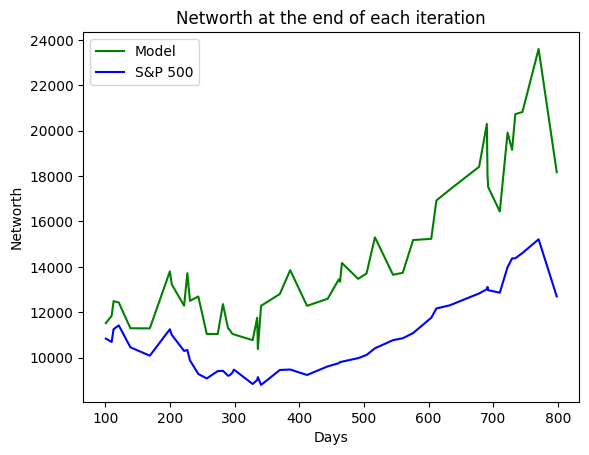

14270.770497608184




In [12]:

for i in tests_to_run:
  t = tests[i-1]
  buy_trigger = t['buy_trigger']    # times standard deviation
  sell_trigger = t['sell_trigger']   # times the avg cost of the security to grow before we sell
  security_age = t['security_age']  # number of days to hold the security before we cut the losses
  lockin_gains_factor = t['lockin_gains_factor'] # times the orignal amount to grow before we lockin the gains.
  prefer_beta = t['prefer_beta']
  mean_type = t["mean_type"]
  print("Test Parameters for " + t['Name'])
  print("=================================")
  pp.pprint(t)
  run_backtest()
  print()
  print("==================================\n")